## 2.1 Import Python Libraries

In [1]:
import boto3, cv2, time, io
import base64
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from PIL import Image

from sagemaker.pytorch import PyTorchPredictor
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import IdentitySerializer

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## 2.2 Check if Endpoint creation is successful and create the predictor

In [2]:
sm_client = boto3.client(service_name="sagemaker")

# Restore the endpoint name stored in the 2_DeployEndpoint.ipynb notebook
%store -r ENDPOINT_NAME
print(f'Endpoint Name: {ENDPOINT_NAME}')

endpoint_created = False
while True:
    response = sm_client.list_endpoints()
    for ep in response['Endpoints']:
        print(f"Endpoint Status = {ep['EndpointStatus']}")
        if ep['EndpointName']==ENDPOINT_NAME and ep['EndpointStatus']=='InService':
            endpoint_created = True
            break
    if endpoint_created:
        break
    time.sleep(5)

Endpoint Name: zomato-images-serverless-endpoint
Endpoint Status = InService


In [3]:
predictor = PyTorchPredictor(
    endpoint_name=ENDPOINT_NAME,
    serializer=IdentitySerializer(content_type='image/jpeg'),
    deserializer=JSONDeserializer()
)


## 2.3 Run Inference and Generate output results

In [4]:
infer_start_time = time.time()

orig_image = cv2.imread('./data/test1.png')

# Encode image as JPEG
_, encoded_img = cv2.imencode('.jpg', orig_image)
payload = encoded_img.tobytes()

result = predictor.predict(payload)

infer_end_time = time.time()

print(f"Inference Time = {infer_end_time - infer_start_time:0.4f} seconds")

Inference Time = 1.9803 seconds


In [5]:
result

{'message': 'Image uploaded successfully to S3',
 's3_path': 'results/result_2024-05-24_23-59-22.jpg'}

In [8]:
# Set up the S3 client
s3 = boto3.client('s3')

# Specify the S3 bucket and file name
bucket_name = 'zomato-project-bucket'
file_name = result['s3_path']

# Step 1: Get the image from S3
fileObj = s3.get_object(Bucket=bucket_name, Key=file_name)
file_content = fileObj['Body'].read()

# Step 2: Load the image with OpenCV
file_bytes = np.asarray(bytearray(file_content), dtype=np.uint8)
result_img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

# Step 3: Convert to RGB
result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

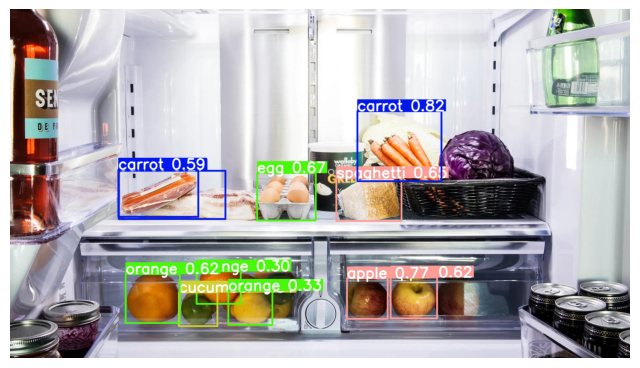

In [9]:
# Display the image using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [10]:
infer_start_time = time.time()

orig_image = cv2.imread('./data/test2.png')

# Encode image as JPEG
_, encoded_img = cv2.imencode('.jpg', orig_image)
payload = encoded_img.tobytes()

result = predictor.predict(payload)

infer_end_time = time.time()

print(f"Inference Time = {infer_end_time - infer_start_time:0.4f} seconds")

Inference Time = 2.2360 seconds


In [11]:
# Set up the S3 client
s3 = boto3.client('s3')

# Specify the S3 bucket and file name
bucket_name = 'zomato-project-bucket'
file_name = result['s3_path']

# Step 1: Get the image from S3
fileObj = s3.get_object(Bucket=bucket_name, Key=file_name)
file_content = fileObj['Body'].read()

# Step 2: Load the image with OpenCV
file_bytes = np.asarray(bytearray(file_content), dtype=np.uint8)
result_img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

# Step 3: Convert to RGB
result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

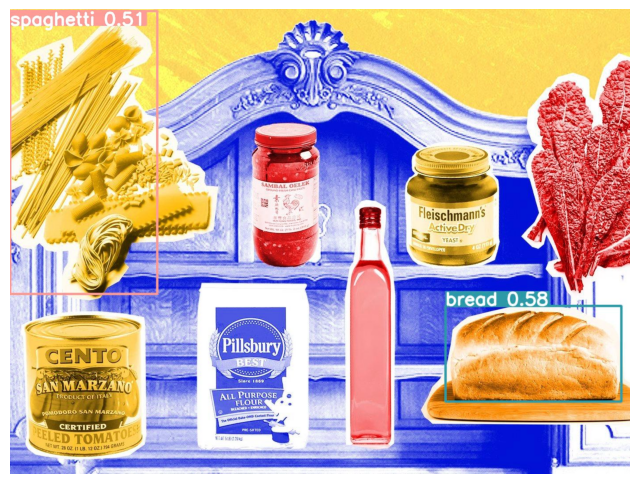

In [12]:
# Display the image using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## 2.4 Cleanup by removing Endpoint, Endpoint Config and Model

In [ ]:
response = sm_client.describe_endpoint_config(EndpointConfigName=ENDPOINT_NAME)
print(response)
endpoint_config_name = response['EndpointConfigName']

# Delete Endpoint
sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)

# Delete Endpoint Configuration
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

# Delete Model
for prod_var in response['ProductionVariants']:
    model_name = prod_var['ModelName']
    sm_client.delete_model(ModelName=model_name)   